In [8]:
import itertools
import time
import os

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import transforms
from sklearn import metrics
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchsummary import summary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/dataset.zip' -d '/content/sample_data/'

In [9]:

class Dataset(Dataset):

    def __init__(self, transform=None, train=True):
        directory = "/content/sample_data/dataset"
        positive = "Positive"
        negative = "Negative"

        positive_file_path = os.path.join(directory, positive)
        negative_file_path = os.path.join(directory, negative)
        positive_files = [os.path.join(positive_file_path, file) for file in os.listdir(positive_file_path) if
                          file.endswith(".jpg")]
        positive_files.sort()
        negative_files = [os.path.join(negative_file_path, file) for file in os.listdir(negative_file_path) if
                          file.endswith(".jpg")]
        negative_files.sort()
        number_of_samples = len(positive_files) + len(negative_files)
        self.all_files = [None] * number_of_samples
        self.all_files[::2] = positive_files
        self.all_files[1::2] = negative_files
        self.transform = transform
        self.Y = torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2] = 1
        self.Y[1::2] = 0

        if train:
            self.all_files = self.all_files[0:30000]
            self.Y = self.Y[0:30000]
            self.len = len(self.all_files)
        else:
            self.all_files = self.all_files[30000:]
            self.Y = self.Y[30000:]
            self.len = len(self.all_files)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):

        image = Image.open(self.all_files[idx])
        y = self.Y[idx]

        if self.transform:
            image = self.transform(image)

        return image, y

In [14]:

def train_in_epochs(num_epochs, train_loader, device, optimizer, criterion, model):
    start = time.time()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_idx, (data, targets) in enumerate(train_loader):

            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)

            loss = criterion(scores, targets)
            optimizer.zero_grad()

            running_loss += loss.item()
            if batch_idx % 100 == 0:
                print('Epoch: {} Batch: {} loss: {}'.format(epoch, batch_idx, loss.item()))

            loss.backward()
            optimizer.step()

    print('Training Completed in: {} secs'.format(time.time() - start))



def check_acc_cnn(loader, model, device):
    num_correct = 0
    num_samples = 0
    pred = []
    targ = []

    model.eval()
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)

            scores = model(data)
            _, predictions = scores.max(1)

            # draw incorrect predictions
            # list_pred = predictions.tolist()
            # list_target = target.tolist()
            # for x in range(len(list_pred)):
            #     if not list_pred[x] == list_target[x]:
            #         imshow(torchvision.utils.make_grid(data[x]),f'AS IS: {list_pred[x]}, TO BE: {list_target[x]}')

            num_correct += (predictions == target).sum()
            num_samples += predictions.size(0)
            pred.extend(predictions.tolist())
            targ.extend(target.tolist())

        print(
            f'With training data  got {num_correct}/{num_samples} with acc: {float(num_correct) / float(num_samples) * 100:.2f}')
    model.train()
    cm = metrics.confusion_matrix(targ, pred)
    plot_confusion_matrix(cm, ["negative", "positive"], normalize=False)



# check if cuda is available
def check_device():
    if torch.cuda.is_available():
        return 'cuda'
    else:
        return 'cpu'


# plot img
def imshow(img, title):
    plt.title(title)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show(block=False)
    plt.pause(0.5)
    plt.close()


# plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Greens):
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title = title
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(i, j, format(cm[i, j], fmt), horizontalalignment="center",
                 color='white' if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel("true label")
    plt.xlabel("predicted label")
    plt.show()


def load_dataset(batch_size):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

    dataset_train = Dataset(transform=transform, train=True)
    train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size)
    dataset_test = Dataset(transform=transform, train=False)
    test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size)

    return [train_loader, test_loader]

In [11]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 32, 3, 1, 'valid')
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv4 = nn.Conv2d(64, 128, 3, 1, 3)
        self.conv5 = nn.Conv2d(128, 256, 3, 1, 'valid')
        self.fc1 = nn.Linear(43264, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)

    def forward(self, x):
        x = f.relu(self.conv1(x))
        x = f.relu(self.conv2(x))
        x = self.pool(x)
        x = f.relu(self.conv2(x))
        x = f.relu(self.conv3(x))
        x = self.pool(x)
        x = f.relu(self.conv4(x))
        x = f.relu(self.conv5(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

In [12]:
def concrete_cnn(device, num_epochs, batch_size):
    print('Training with CNN - Crack detection ')

    dataset = load_dataset(batch_size)
    model = CNN()
    model = model.to(device)
    summary(model, (3, 227, 227))

    criterion = nn.CrossEntropyLoss()  # loss function with softmax
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adaptive Movement Estimation algorithm

    train_in_epochs(num_epochs, dataset[0], device, optimizer, criterion, model)

    check_acc_cnn(dataset[0], model, device)
    check_acc_cnn(dataset[1], model, device)

Training with CNN - Crack detection 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 113, 113]             896
            Conv2d-2         [-1, 32, 111, 111]           9,248
         MaxPool2d-3           [-1, 32, 55, 55]               0
            Conv2d-4           [-1, 32, 53, 53]           9,248
            Conv2d-5           [-1, 64, 53, 53]          18,496
         MaxPool2d-6           [-1, 64, 26, 26]               0
            Conv2d-7          [-1, 128, 30, 30]          73,856
            Conv2d-8          [-1, 256, 28, 28]         295,168
         MaxPool2d-9          [-1, 256, 13, 13]               0
           Linear-10                  [-1, 128]       5,537,920
           Linear-11                   [-1, 32]           4,128
           Linear-12                   [-1, 10]             330
Total params: 5,949,290
Trainable params: 5,949,290
Non-trainable 

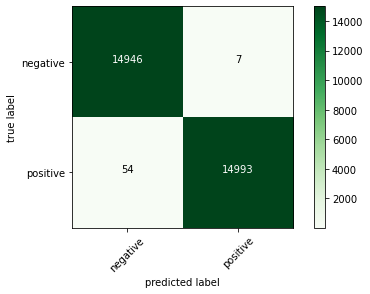

With training data  got 9963/10000 with acc: 99.63


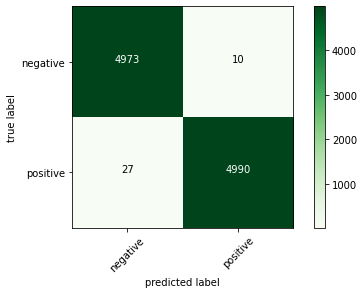

In [16]:
num_epochs = 10
batch_size = 64
device = check_device()

concrete_cnn(device, num_epochs, batch_size)